# Equipotential lines for charges in 2D plane.

Here we will construct poisson solver for a 2D square boundary
using a variation of Fast Fourier Transform and dicrete sine transform.

There are 4 types of discrete sine transform,you can read more about them in
wikipedia http://en.wikipedia.org/wiki/Discrete_sine_transform

We will solve the 2D electrostatic equation for square boundary,in

$\epsilon_0=1~ units$

The poisson equation $\nabla^2 u= \rho$ can be solved using fourier transform technique.

The poisson equation solver in 2D basically uses the matrix representation of the discrete poisson equation.

As an example we plot the equipotential lines for 2 charges in 2D plane.

This uses dst function(Type -I) from either fft.fftpack or a seperate
dst package



/opt/intel/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/intel/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


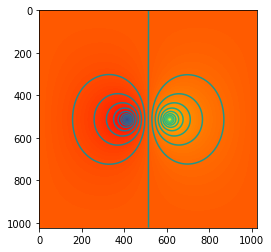

In [23]:
#This uses dst function(Type -I) from either fft.fftpack or a seperate


from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft,fft2,ifft2,ifft,irfft2,rfft2
import random as random
from mpl_toolkits.mplot3d import Axes3D
#Define a function for discrete sin transform using fft algorithm,by symmetrizing the function x


def dst(x,axis=-1):
    """Discrete Sine Transform (DST-I)

    Implemented using 2(N+1)-point FFT
    xsym = r_[0,x,0,-x[::-1]]
    DST = (-imag(fft(xsym))/2)[1:(N+1)]

    adjusted to work over an arbitrary axis for entire n-dim array
    """
    n = len(x.shape)
    N = x.shape[axis]
    slices = [None]*3
    for k in range(3):
        slices[k] = []
        for j in range(n):
            slices[k].append(slice(None))
    newshape = list(x.shape)
    newshape[axis] = 2*(N+1)
    xsym = np.zeros(newshape,np.float)
    slices[0][axis] = slice(1,N+1)
    slices[1][axis] = slice(N+2,None)
    slices[2][axis] = slice(None,None,-1)
    for k in range(3):
        slices[k] = tuple(slices[k])
    xsym[slices[0]] = x
    xsym[slices[1]] = -x[slices[2]]
    DST = fft(xsym,axis=axis)
    #print xtilde
    return (-(DST.imag)/2)[slices[0]]

#Define 2 dimensional DST, the idst is same as DST because of symmetry


def dst2(x,axes=(-1,-2)):
    return dst(dst(x,axis=axes[0]),axis=axes[1])

def idst2(x,axes=(-1,-2)):
    return dst(dst(x,axis=axes[0]),axis=axes[1])


#Now define the poisson solver in 2D square boundary using the algorithm described above,this method can be
#generalised to arbitary retangular boundary


def fft_poisson(f,h):

	m,n=f.shape
	f_bar=np.zeros([n,n])
	u_bar = f_bar			# make of the same shape
	u = u_bar

	f_bar=idst2(f)			# f_bar= fourier transform of f

	f_bar = f_bar * (2/n+1)**2  #Normalize
	#u_bar =np.zeros([n,n])
	pi=np.pi
	lam = np.arange(1,n+1)
	lam = -4/h**2 * (np.sin((lam*pi) / (2*(n + 1))))**2 #$compute $\lambda_x$
	#for rectangular domain add $lambda_y$
	for i in xrange(0,n):
		for j in xrange(0,n):
			u_bar[i,j] = (f_bar[i,j]) / (lam[i] + lam[j])

	u=dst2(u_bar)				#sine transform back
	u= u * (2/(n+1))**2			#normalize ,change for rectangular domain
	return u


#Fix the initial parameters,domain of the equation etc.
#set bounds a,b,parameters of the system length

a = 0; b = 1;	
alpha=10				#alpha is grid points=2^alpha
n=2**alpha
L=b-a					#length of system

xe =np.linspace(a,b,n); 
ye =np.linspace(a,b,n);
x, y = np.meshgrid(xe,ye)

h=L/(n);			#size 
h2 = h**2;			#h squared
hx2=h2; 			#started with a cube,hx2=hy2
hy2=h2;
f=np.zeros([n,n]);
#We put charges in the field.

#Putting a random negetive charge in the field alog with a positve charge


#initial conditions

#f[round(n/2):n,round(n/2):n]=10; #Initial condition
#create a dipole
f[round((n+1)/2),round((n+1)/2-100)]=1 #positive charge
f[round((n+1)/2),round((n+1)/2+100)]=-1 #negetive charge

#f[random.randint(0,n),random.randint(0,n)]=-10	#put a charge at random place

nx,ny=np.array(f.shape)-1		 #last index
U=np.zeros([n,n])


#set boundary conditions
# BOUNDARY CONDITIONS
#set U(x,y)=g(x,y)
#here we choose zero-Dirichlet Boundary conditions
U[0,:]=0
U[nx,:]=0#5e-5
U[:,0]=0
U[:,ny]=0

##homogenize boundary condition

f[1,:]=f[1,:]+U[0,:]/hx2;
f[nx-1,:]=f[nx-1,:]+U[n-1,:]/hx2;

f[:,1]=f[:,1]+U[:,0]/hy2;
f[:,ny-1]=f[:,ny-1]+U[:,n-1]/hy2;

#Solve the equation:
U=fft_poisson(f,h)

plt.figure()
plt.imshow((U),cmap='hot')
plt.contour(U,50)
#plt.contour(f)

plt.show()


 
